# Timing & Memory

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from memory_profiler import memory_usage

import empymod

hankel_dlf_n = empymod.transform.hankel_dlf
hankel_dlf_c = empymod.transform.hankel_cdlf

In [2]:
inp = {
    'src': [0, 0, 100, 10, 40],
    'depth': [0, 300, 600, 900, 1200],
    'res': [1e20, .3, 1, 50, 1, 10],
    'msrc': False,
    'mrec': False,
    'verb': 1
}

In [3]:
atol, rtol = 1e-20, 1e-8
print(f"Tested with rtol={rtol}, atol={atol}")
trun = {}
mrun = {}
for pts_per_dec in [0, -1]:
    print(f"** pts_per_dec: {pts_per_dec}")
    inp['htarg'] = {'pts_per_dec': pts_per_dec}
    trun[pts_per_dec] = {'numba': np.array([]), 'C': np.array([]), 'n': np.array([])}
    mrun[pts_per_dec] = {'numba': np.array([]), 'C': np.array([])}
    for nfreq, nrec in zip([1, 10, 10, 100, 100, 1000, 1000], [1, 1, 10, 10, 100, 100, 1000]):
        #for nfreq, nrec in zip([1, 10, 10], [1, 1, 10]):
        if nfreq*nrec > 100*100 and pts_per_dec == 0:
            continue
        
        frequencies = np.logspace(-3, 3, nfreq)
        receivers = [np.linspace(10, 1000, nrec), 50+np.zeros(nrec), 200, 30, 20]
        print(f"nfreq x nrec: {nfreq:8d} x {nrec:8d} = {nfreq*nrec:12d}; ", end="")
        trun[pts_per_dec]['n'] = np.r_[trun[pts_per_dec]['n'], nfreq*nrec]

        inp['freqtime'] = frequencies
        inp['rec'] = receivers

        empymod.transform.hankel_dlf = hankel_dlf_n
        nresult = empymod.bipole(**inp)
        out = %timeit -q -o empymod.bipole(**inp)
        trun[pts_per_dec]['numba'] = np.r_[trun[pts_per_dec]['numba'], out.average]
        mrun[pts_per_dec]['numba'] = np.r_[mrun[pts_per_dec]['numba'], max(memory_usage((empymod.bipole, (), inp)))]

        empymod.transform.hankel_dlf = hankel_dlf_c
        cresult = empymod.bipole(**inp)
        out = %timeit -q -o empymod.bipole(**inp)
        trun[pts_per_dec]['C'] = np.r_[trun[pts_per_dec]['C'], out.average]
        mrun[pts_per_dec]['C'] = np.r_[mrun[pts_per_dec]['C'], max(memory_usage((empymod.bipole, (), inp)))]

        same = np.allclose(nresult, cresult, rtol=rtol, atol=atol)
        error = np.abs(nresult - cresult)
        print(f"  Data {['are NOT', 'ARE'][same]} the same; "
              f"max abs error: {np.max(error):.4g}; max rel error: "
              f"{np.max(error/np.abs(cresult)):.4g}")

Tested with rtol=1e-08, atol=1e-20
** pts_per_dec: 0
nfreq x nrec:        1 x        1 =            1;   Data are NOT the same; max abs error: 2.151e-09; max rel error: 0.3476
nfreq x nrec:       10 x        1 =           10;   Data are NOT the same; max abs error: 2.151e-09; max rel error: 0.3807
nfreq x nrec:       10 x       10 =          100;   Data are NOT the same; max abs error: 2.151e-09; max rel error: 0.4331
nfreq x nrec:      100 x       10 =         1000;   Data are NOT the same; max abs error: 2.151e-09; max rel error: 0.6084
nfreq x nrec:      100 x      100 =        10000;   Data are NOT the same; max abs error: 2.151e-09; max rel error: 0.8632
** pts_per_dec: -1
nfreq x nrec:        1 x        1 =            1;   Data are NOT the same; max abs error: 2.151e-09; max rel error: 0.3476
nfreq x nrec:       10 x        1 =           10;   Data are NOT the same; max abs error: 2.151e-09; max rel error: 0.3807
nfreq x nrec:       10 x       10 =          100;   Data are NOT th

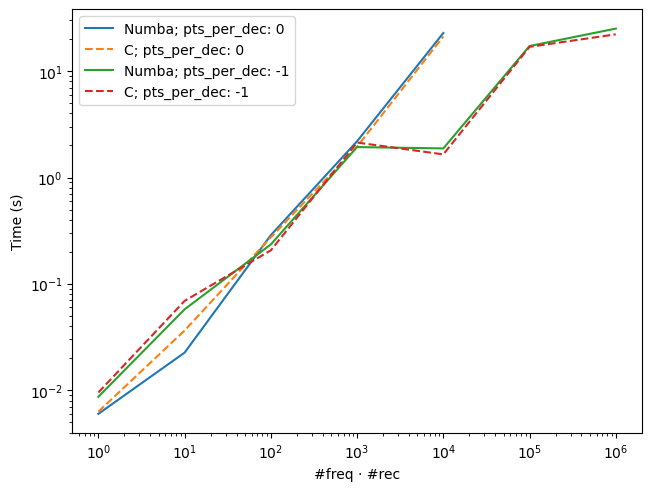

In [8]:
fig, ax = plt.subplots(constrained_layout=True)

for i, pts_per_dec in enumerate([0, -1]):
    ax.loglog(trun[pts_per_dec]['n'], trun[pts_per_dec]['numba'], label=f"Numba; pts_per_dec: {pts_per_dec}")
    ax.loglog(trun[pts_per_dec]['n'], trun[pts_per_dec]['C'], "--", label=f"C; pts_per_dec: {pts_per_dec}")
ax.set_xlabel('#freq · #rec')
ax.set_ylabel('Time (s)')
ax.legend()
fig.savefig('Runtime.png', dpi=300)

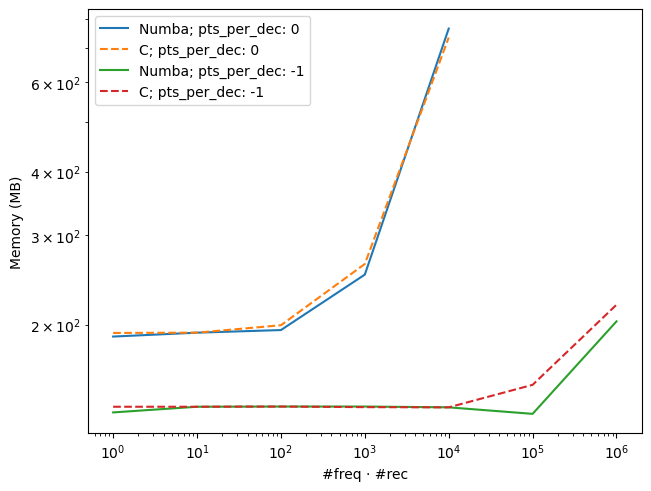

In [9]:
fig, ax = plt.subplots(constrained_layout=True)

for i, pts_per_dec in enumerate([0, -1]):
    ax.loglog(trun[pts_per_dec]['n'], mrun[pts_per_dec]['numba'], label=f"Numba; pts_per_dec: {pts_per_dec}")
    ax.loglog(trun[pts_per_dec]['n'], mrun[pts_per_dec]['C'], "--", label=f"C; pts_per_dec: {pts_per_dec}")
ax.set_xlabel('#freq · #rec')
ax.set_ylabel('Memory (MB)')
ax.legend()
fig.savefig('Memory.png', dpi=300)

In [6]:
empymod.Report()

--------------------------------------------------------------------------------
  Date: Fri Sep 20 13:01:18 2024 CEST

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 7.6 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:07:37)
  [GCC 12.3.0]

             numpy : 1.26.3
             scipy : 1.12.0
             numba : 0.59.0
           empymod : 2.3.2.dev8+g842ee4c
            libdlf : 0.2.0
           IPython : 8.21.0
        matplotlib : 3.8.3
--------------------------------------------------------------------------------